In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import emoji
import demoji

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def Evaluate(y_test,y_pred):
    

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [3]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        tweet = demoji.replace_with_desc(tweet,sep='*')
   
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [4]:
def load_models():

    # Load the vectoriser.
    file = open('vectoriser-ngram.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the BNB Model.
    file = open('Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    #df = df.replace([0,1], ["Negative","Positive"])
    return df


In [5]:
df = pd.read_csv('test_Iphone12.csv')

In [6]:
df

,Unnamed: 0,user,tweet,sentiment_label
0,0,T.,iPhone12 mini is approaching! #apple #iphone12...,1
1,1,Jake Krol,It’s the 2020 iPhone family. #iPhone12Mini #iP...,1
2,2,Priya Magotra,@zomato I want to buy iphone12 pro for my hubb...,1
3,3,Hatsune Miku Santos,@Vince_Lexan I did what you ask for. I have wa...,0
4,4,宮城 寿美,@yukyeal iPhone12？,0
...,...,...,...,...
495,495,Kat Ced,Slash Price Now! I found this fantastic bargai...,1
496,496,Kat Ced,Slash Price Now! I found this fantastic bargai...,1
497,497,DJoseR🩺,@Apple It better not be a new iPhone... i just...,1
498,498,moneycontrol,#Tech: The iPhone 12 comes with a bunch of new...,1


In [8]:
df['sentiment_label'].value_counts()

1    326
0    174
Name: sentiment_label, dtype: int64

In [9]:
text = list(df.tweet)
y_test = list(df.sentiment_label)

In [10]:
vectoriser, LRmodel = load_models()
    
df_t = predict(vectoriser, LRmodel, text)
print(df_t.head())

                                                text  sentiment
0  iPhone12 mini is approaching! #apple #iphone12...          1
1  It’s the 2020 iPhone family. #iPhone12Mini #iP...          1
2  @zomato I want to buy iphone12 pro for my hubb...          1
3  @Vince_Lexan I did what you ask for. I have wa...          0
4                                 @yukyeal iPhone12？          1


In [11]:
y_pred = list(df_t.sentiment)

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       174
           1       0.89      0.90      0.90       326

    accuracy                           0.86       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.86      0.86      0.86       500



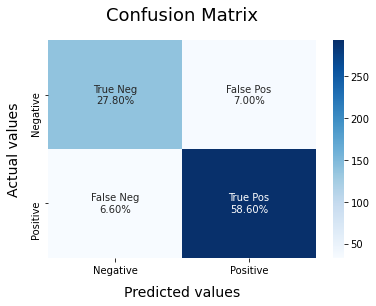

In [12]:
Evaluate(y_test,y_pred)